Import basic modules and point to GCRCatalogs version containing reader for the agn catalog.
This reader ingests the agn_mean_mags catalog and adds the agn fluxes to the original broadband fluxes and computes
the resulting filter magnitudes.

In [1]:
import sys
import numpy as np
sys.path.insert(0, '/global/u1/k/kovacs/gcr-catalogs_agn/') 
import GCRCatalogs
%matplotlib inline
from matplotlib import pyplot as plt

Read in catalogs and setup quantities to fetch. We use cosmoDC2_v1.1.4_small (~1/8 of total) so that notebook runs faster.

In [2]:
agn = GCRCatalogs.load_catalog('AGN_mean_mags_v1.1.4')
dc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
#dc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [3]:
all_bands = ['mag_{}_lsst'.format(b) for b in ['g', 'r', 'i', 'z']]
noagn_bands = ['mag_{}_noagn_lsst'.format(b) for b in ['g', 'r', 'i', 'z']]
other = ['redshift', 'galaxy_id']
agn_q = all_bands + noagn_bands + other
dc2_q = all_bands + other
agn_data = agn.get_quantities(agn_q)
print(agn_data.keys())

dict_keys(['redshift', 'mag_g_lsst', 'mag_g_noagn_lsst', 'mag_z_lsst', 'mag_i_lsst', 'mag_i_noagn_lsst', 'galaxy_id', 'mag_r_noagn_lsst', 'mag_z_noagn_lsst', 'mag_r_lsst'])


In [4]:
dc2_data = dc2.get_quantities(dc2_q)
print(dc2_data.keys())

dict_keys(['redshift', 'mag_g_lsst', 'mag_i_lsst', 'mag_z_lsst', 'galaxy_id', 'mag_r_lsst'])


The next two cells find the galaxies in the agn catalog that are also in cosmoDC2_v1.1.4_small and make a new AGN dict of only that subsample. Once we have that, we can compare cosmoDC2 with this AGN catalog

In [6]:
def get_galaxy_mask(cat1, cat2, field='galaxy_id'):
    mask = np.in1d(cat2[field], cat1[field])
    print('{}/{} selected'.format(np.count_nonzero(mask), len(cat2[field])))
    return mask

In [7]:
gmask = get_galaxy_mask(dc2_data, agn_data)
AGN_data = {}
for k, v in agn_data.items():
    AGN_data[k] = agn_data[k][gmask]

print(len(AGN_data['galaxy_id']))

4024486/31029942 selected
4024486


Define some useful masking functions to select subsamples in redshift and magnitude

In [8]:
def get_mask(data, band, mag_cut, q_template, fh=None):
    quantity = q_template.format(band)
    mask = (data[quantity] < mag_cut)
    if fh:
        fh.write('Number: {} < {} = {}\n'.format(quantity, mag_cut, np.count_nonzero(mask)))
    return mask

In [9]:
def get_masks(data, band, q_template, mag_lo=18., mag_hi=30., fh=None):
    masks = {}
    for mag_cut in np.arange(mag_lo, mag_hi):
        masks['{}<{}'.format(band, mag_cut)] = get_mask(data, band, mag_cut, q_template, fh=fh)
        
    return masks

In [10]:
def get_zmasks(data, zlo=0., zhi=2.5, dz=0.5, fh=None):
    zmasks = {}
    for zmin, zmax in zip(np.arange(zlo, zhi, dz), np.arange(zlo+dz, zhi+dz, dz)):
        zmasks['{}<z<{}'.format(zmin, zmax)] = (data['redshift'] > zmin) & (data['redshift'] < zmax)
        if fh:
            fh.write('Number: {}<z<{} = {}\n'.format(zmin, zmax, np.count_nonzero(zmasks['{}<z<{}'.format(zmin, zmax)])))
        
    return zmasks

In [11]:
bands = ['g', 'r', 'i', 'z']
def get_data_masks(data, labels, templates, bands, zlo=0., zhi=2.5, dz=0.5, filename='numbers.txt'):
    data_masks = {}
    data_zmasks = {}
    joint_masks = {}
    with open(filename, 'w') as fh:
        for data, template, label in zip(data, templates, labels):
            data_zmasks[label] = get_zmasks(data, fh=fh, zlo=zlo, zhi=zhi, dz=dz)
            joint_masks[label] = {}
            data_masks[label] = {}
            for band in bands:
                data_masks[label].update(get_masks(data, band, template, fh=fh))
            #print(data_masks[label].keys())
    
            for kz, vz in data_zmasks[label].items():
                joint_masks[label][kz] = {}
                for k, v in data_masks[label].items():
                    joint_masks[label][kz][k] = (vz) & (v)
                    fh.write('Number: {} & {} = {}\n'.format(kz, k, np.count_nonzero(joint_masks[label][kz][k])))
                    
    return data_masks, data_zmasks, joint_masks

In [12]:
data_masks, data_zmasks, joint_masks = get_data_masks([AGN_data, dc2_data], ['agn', 'dc2'],
                                                      ['mag_{}_noagn_lsst', 'mag_{}_lsst'], bands)

print('done')

done


Define a function to calculate the fraction of galaxies with magnitudes affected by agn contributions

In [13]:
def get_fractions(keyn, keyd, bands, joint_masks):
    fractions = {}
    for band in bands:
        fractions[band] = {}
        for kz, vz in joint_masks[keyn].items():
            bkeys = [k for k in vz.keys() if band in k]
            mags = np.asarray([k.split('<')[-1] for k in bkeys]).astype(float)
            num = [np.count_nonzero(joint_masks[keyn][kz][k]) for k in bkeys]
            den = [np.count_nonzero(joint_masks[keyd][kz][k]) for k in bkeys]
            fractions[band][kz] = {'frac': np.asarray(num).astype(float)/np.asarray(den).astype(float),
                                   'mag': mags}
            #print(band, kz, fractions[band][kz])
            
    return fractions

In [14]:
fractions = get_fractions('agn', 'dc2', bands, joint_masks)

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Plot the fractions for the available masks

In [46]:
def plot_fractions(bands, fractions):
    fig, ax_all = plt.subplots(1, len(bands), figsize=(16, 6), sharey='row')
    for band, ax in zip(bands, ax_all.flat):
        for kz, vz in fractions[band].items():
            ax.plot(vz['mag'], vz['frac'], label=kz)

        ax.legend(loc='best',title='{} band'.format(band))
        ax.set_xlabel('$m_{}$'.format(band))
        ax.set_ylabel('Fraction ($<m_{}$)'.format(band))
        
    figname = 'fractions.png'
    print('Saving {}'.format(figname))
    fig.savefig(figname, bbox_inches='tight')  

Saving fractions.png


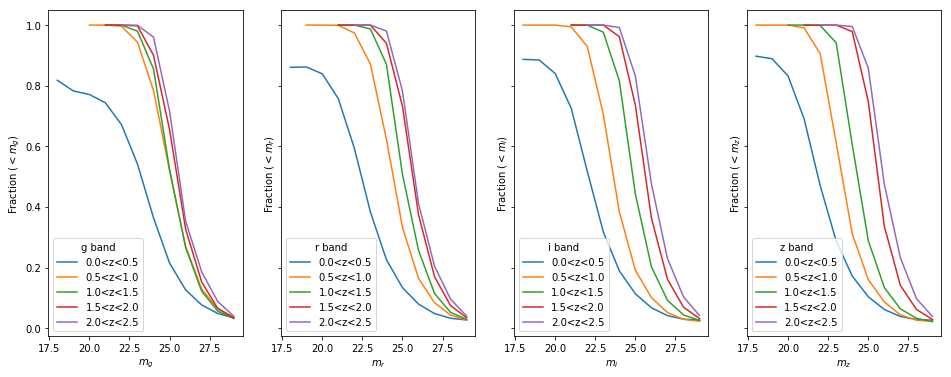

In [47]:
plot_fractions(bands, fractions)

Now we want to make a composite catalog including the agn magnitudes to see the effect on overall distributions.
First define a function to return an array with the locations of all the galaxies in the AGN dict. We expect to find a match for every galaxy.

In [20]:
def get_overlap(ds1, ds2, key='galaxy_id'):
    orig_indices = ds1[key].argsort()
    index = orig_indices[np.searchsorted(ds1[key][orig_indices], ds2[key])]
    print('Found {}/{}'.format(len(index), len(ds2[key])))

    return index

In [21]:
#index = get_overlap(dc2_data[data_zmasks['dc2'][zkey]], AGN_data[data_zmasks['agn'][zkey]])
index = get_overlap(dc2_data, AGN_data)

Found 4024486/4024486


Define a function to check that the unmodified magnitudes in the AGN catalog match those in cosmoDC2

In [22]:
def check_mags(ds1, ds2, keys1, keys2, index):
    for key1, key2 in zip(keys1, keys2):
        if not all(np.isclose(ds1[key1][index], ds2[key2])):
            print('Mismatch for {} an {}'.format(key1, key2))
    return        

Define a function to create new columns in the cosmoDC2 catalog that contain the contributions from the AGN catalog for those galaxies that are in common, but otherwise are unchanged.

In [ ]:
def add_columns(ds1, ds2, index, keys, add_on='+agn'):
    for key in keys:
        new_key = key + add_on
        ds1[new_key] = ds1[key].copy()
        ds1[new_key][index] = ds2[key]
        
    return ds1

In [24]:
check_mags(dc2_data, AGN_data, all_bands, noagn_bands, index)
dc2_data = add_columns(dc2_data, AGN_data, index, all_bands)

Check that the new keys have been added and then make some plots

In [26]:
print(dc2_data.keys())

dict_keys(['redshift', 'mag_g_lsst', 'mag_i_lsst', 'mag_z_lsst', 'galaxy_id', 'mag_r_lsst', 'mag_g_lsst+agn', 'mag_r_lsst+agn', 'mag_i_lsst+agn', 'mag_z_lsst+agn'])


In [48]:
def plot_mags(data, zmask, zkey, bands, key_template, label='lsst', add_on='+agn', mlo=15., mhi=30.):
    mbins = np.arange(mlo, mhi, 0.5)
    fig, ax_all = plt.subplots(1, len(bands), figsize=(16, 5), sharey='row')
    for n, (band, ax) in enumerate(zip(bands, ax_all.flat)):
        key = key_template.format(band)
        ax.hist(data[key+add_on][zmask], bins=mbins, color='red', label=label+add_on, alpha=0.5)
        ax.hist(data[key][zmask], bins=mbins, color='blue', label=label, alpha=0.5)
        ax.legend(loc='best',title='{} band'.format(band))
        ax.set_xlabel('$m_{}$'.format(band))
        if n==0:
            ax.set_ylabel('Number')
        else:
            for alabel in ax.get_yticklabels():
                alabel.set_visible(False)
        ax.set_yscale('log')

    fig.suptitle(zkey, fontsize=14)
    fig.subplots_adjust(wspace=0)
    figname = 'mag_{}.png'.format(zkey)
    print('Saving {}'.format(figname))
    fig.savefig(figname, bbox_inches='tight')  

Run the plots for the z-ranges selected in the masks and check the effect on the overall distributions.
Note the log scale. The distributions in blue show the original cosmoDC2 distributions. Those in red show the distribution with the agn component included.  The effect gets worse with increasing redshift. 

Saving mag_0.0<z<0.5.png
Saving mag_0.5<z<1.0.png
Saving mag_1.0<z<1.5.png
Saving mag_1.5<z<2.0.png
Saving mag_2.0<z<2.5.png


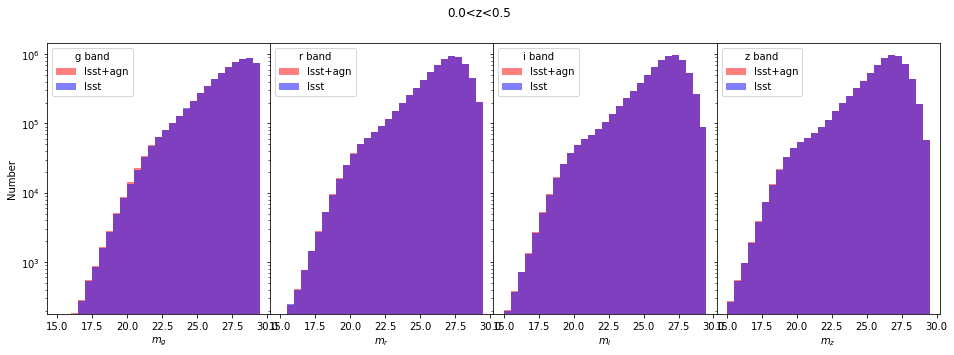

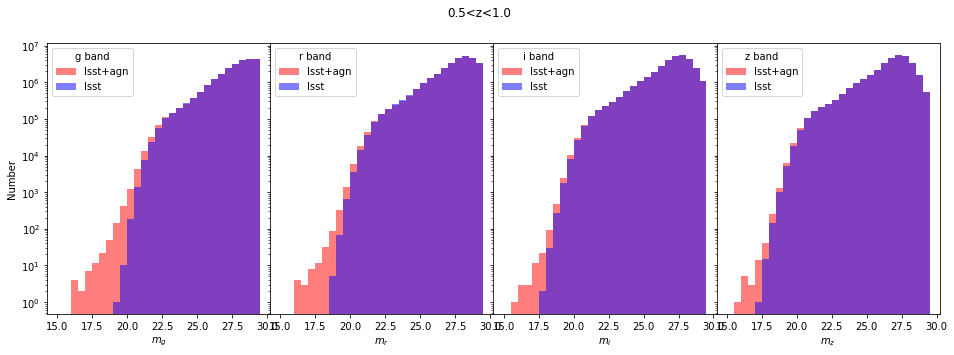

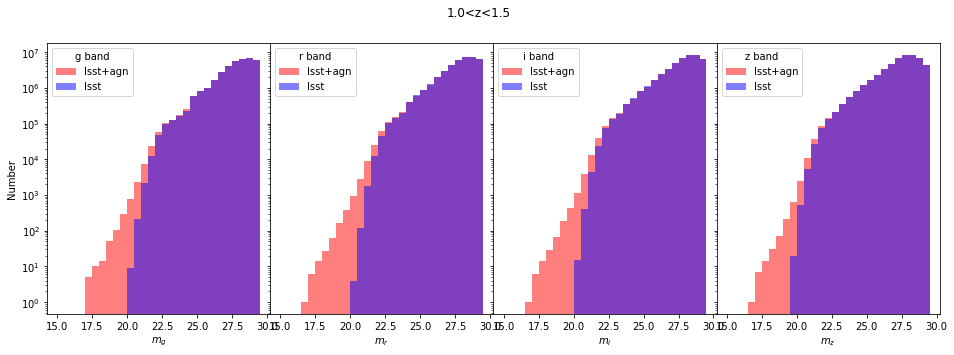

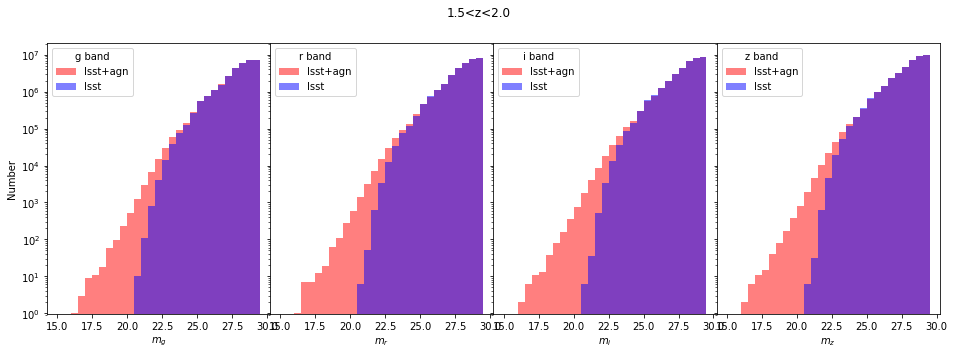

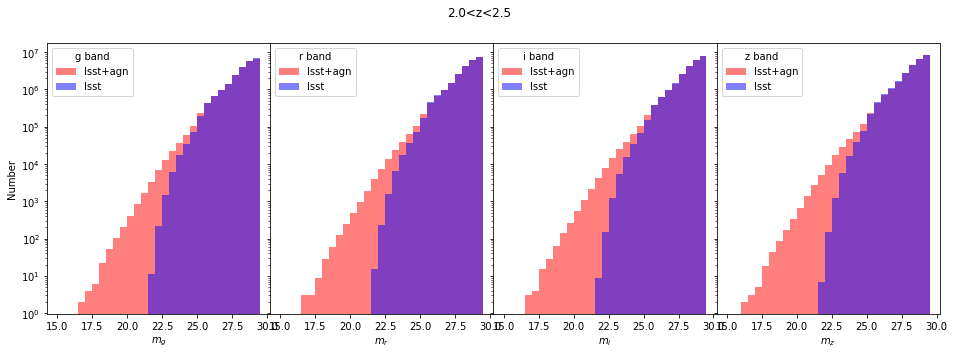

In [50]:
for kz, vz in data_zmasks['dc2'].items():
    plot_mags(dc2_data, vz, kz, bands, 'mag_{}_lsst')